In [1]:
from __future__ import print_function, division
import scipy
from keras.models import load_model
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import keras
import pandas as pd
import helpers as H
from tqdm import tqdm

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import cv2

Using TensorFlow backend.


In [2]:
#Root directory of the project
ROOT_DIR = os.path.abspath(".")
MODEL_PATH = os.path.join(ROOT_DIR, "models")
TEST_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")
TEST_DATASET_PATH

'E:\\FastMRI\\MRI-reconstruction\\dataset'

In [3]:
TEST_LOW_DIR = "singlecoil_test_3D_images/"
TEST_IMAGES_DIR_PATH = os.path.join(TEST_DATASET_PATH, TEST_LOW_DIR)
TEST_IMAGES_DIR_PATH

'E:\\FastMRI\\MRI-reconstruction\\dataset\\singlecoil_test_3D_images/'

In [4]:
len(os.listdir(TEST_IMAGES_DIR_PATH))

108

In [5]:
test_images = [os.path.join(TEST_IMAGES_DIR_PATH, x) for x in os.listdir(TEST_IMAGES_DIR_PATH)]
len(test_images)

108

### Load the model

In [6]:
model = load_model(os.path.join(MODEL_PATH, 'g_AB.h5'), custom_objects={'InstanceNormalization':InstanceNormalization})
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\Aiman\Anaconda3\envs\sticker\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 160, 160, 32) 544         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 160, 160, 32) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
instance_normalization_7 (Insta (None, 160, 160, 32) 2           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
conv2d_12 

In [7]:
##img = H.normalize(img)
#flat = img.flatten()
#min(flat), max(flat)

In [8]:
def predict(img_3d):
    
    recon = []
    # Make it 4D for inference
    img_3d = np.moveaxis(img_3d, 0, 2) # whc
    slices = img_3d.shape[-1]

    # iterate over each slice and save
    for i in range(slices):
        img = img_3d[:,:,i]
        img = H.normalize(img) # Normalize image
        img =  img[np.newaxis,:,:,np.newaxis]
        img = model.predict(img)
        img = np.squeeze(img, axis=0)
        img = np.reshape(img, (320, 320))
        recon.append(img)
    
    recon = np.array(recon)
    return recon
        

* Calc min max from input
* Norm and predict
* Transofrm to min max via: img = img * max - min

In [50]:
fname = test_images[1]
a = np.load(fname)
a.shape

(33, 320, 320)

In [51]:
out_3d = H.normalize(predict(a))
out_3d.shape

(33, 320, 320)

In [52]:
def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

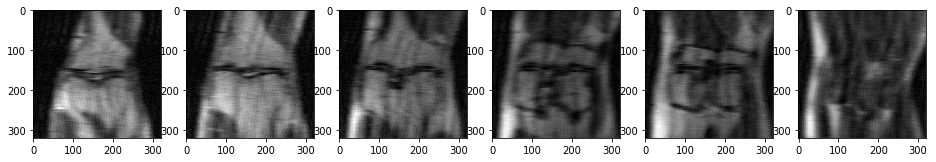

In [53]:
slice_num = [12, 16, 19, 22, 24, 28]
show_slices(a, slice_num, cmap='gray')

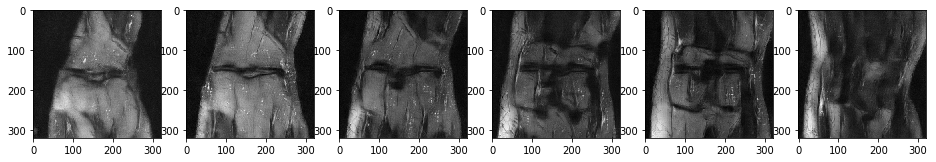

In [54]:
show_slices(out_3d, slice_num, cmap='gray')

0.0 1.0


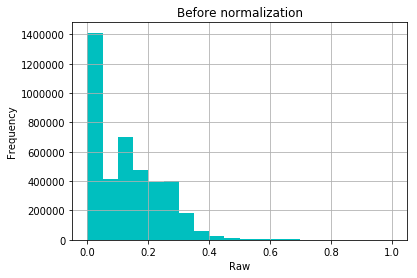

In [72]:
img_flat = H.normalize(a).flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

0.0 1.0


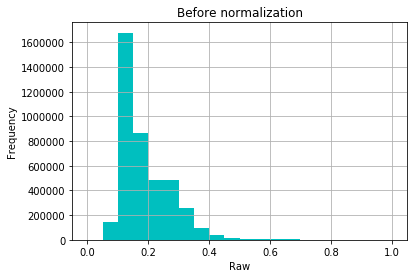

In [74]:
img_flat =out_3d.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [19]:
fname[-18:-4]+".h5"

'file1002452_v2.h5'

In [20]:
RESULTS = "results_input"
H.create_directory("{}/{}".format(TEST_DATASET_PATH, RESULTS))
RESULTS_PATH = os.path.join(TEST_DATASET_PATH, RESULTS)
RESULTS_PATH

'E:\\FastMRI\\MRI-reconstruction\\dataset\\results_input'

In [21]:
res = {}

for path in tqdm(test_images):
    name = path[-18:-4]+".h5"
    
    vol = np.load(path)
    output = H.normalize(predict(vol))
    
    res[name] = output
    
    #np.save("{}/{}".format(RESULTS_PATH, name), output)

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [03:09<00:00,  1.82s/it]


In [22]:
c=0
for n, d in res.items():
    print(n, d.shape)
    c+=1
    if c is 4:
        break

file1000022_v2.h5 (37, 320, 320)
file1000036_v2.h5 (33, 320, 320)
file1000055_v2.h5 (37, 320, 320)
file1000056_v2.h5 (33, 320, 320)


In [23]:
from fastMRI.common import utils as U
from pathlib import Path

In [24]:
RESULTS_FINAL = "results_final_input"
H.create_directory("{}/{}".format(TEST_DATASET_PATH, RESULTS_FINAL))
RESULTS_PATH = os.path.join(TEST_DATASET_PATH, RESULTS_FINAL)

In [25]:
RESULTS_PATH

'E:\\FastMRI\\MRI-reconstruction\\dataset\\results_final_input'

In [26]:
U.save_reconstructions(res, Path(RESULTS_PATH))